In [2]:
# Step 1: Install required libraries :contentReference[oaicite:0]{index=0}:contentReference[oaicite:1]{index=1}
!pip install transformers datasets scikit-learn shap umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [3]:
# Step 2: Mount Drive or upload CSV :contentReference[oaicite:2]{index=2}:contentReference[oaicite:3]{index=3}
from google.colab import files, drive

# Option A: upload directly
uploaded = files.upload()  # then select model_data_2.csv

# Option B: mount Google Drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/path/to/your/folder


Saving model_data_2.csv to model_data_2.csv


In [3]:
# Step 3: Imports and device setup
import pandas as pd
import torch
import pickle
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from google.colab import files as colab_files

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
# # Step 4: Load & prepare your data :contentReference[oaicite:4]{index=4}:contentReference[oaicite:5]{index=5}
# df = pd.read_csv("model_data_.csv")

# # If your file already has 'text' and 'label', skip the next two lines.
# # Otherwise—for example, if you have title/source columns—combine them:
# # df['text'] = df['title'].fillna('') + ' ' + df['source'].fillna('') + ' ' + df['text'].fillna('')

# dataset = Dataset.from_pandas(df[['text', 'label']])


In [5]:
import pandas as pd
from datasets import Dataset

df = pd.read_csv("model_data_2.csv",encoding='utf-8')
print(df.columns)
print(df.head())


Index(['title', 'text', 'source', 'label', 'complete', 'cleaned_text'], dtype='object')
                                               title  \
0  Tiny implantable device short-circuits hunger ...   
1  Scientists report CRISPR restores effectivenes...   
2  Probiotics could help millions of patients suf...   
3  Yes Please to Yogurt and Cheese: The New Impro...   
4  Johns Hopkins team identifies promising diagno...   

                                                text  \
0  MADISON, Wis. -- More than 700 million adults ...   
1  Wilmington, DE, December 17, 2018 - The CRISPR...   
2  About 3 million people in the US are diagnosed...   
3  Newswise — Thousands of people can take heart ...   
4  Researchers at Johns Hopkins Medicine have ide...   

                     source label  \
0   https://web.archive.org  Fake   
1   https://web.archive.org  Fake   
2   https://web.archive.org  Fake   
3  https://www.newswise.com  Fake   
4   https://web.archive.org  Fake   

               

In [6]:
# 2) Pick the column you really want to feed into BERT.
#    In your case you have both 'text' (the raw paragraphs) and
#    'cleaned_text' (lowercased, punctuation-stripped). Use whichever
#    you prefer; here I'll use 'cleaned_text'.
df["cleaned_text"] = df["cleaned_text"].fillna("").astype(str)

# 3) Rename it to exactly "text" for the tokenizer function:
hf_df = df.rename(
    columns={"cleaned_text": "text"}
)

In [7]:
df['label']

,label
0,Fake
1,Fake
2,Fake
3,Fake
4,Fake
...,...
9633,NaN
9634,false
9635,NaN
9636,NaN


In [8]:
# 1. Bucket raw claims into named labels
df.dropna(subset=["label"], inplace=True)
df["label"] = df["label"].apply(lambda x: tuple(x) if isinstance(x, list) else x)

df["label"] = df["label"].map({
    "Realiable": "Reliable",
    "false": "Fake",
    "Unreliable": "Unreliable",
    "SUPPORTS": "Reliable",
    "REFUTES": "Fake",
    "NOT ENOUGH INFO": "NOT ENOUGH INFO",
    "unknown": "NOT ENOUGH INFO",
    "Not Enough Experts": "NOT ENOUGH INFO",
    "true": "Reliable",
    "mixture": "Unreliable",
    "Inaccurate": "Unreliable",
    "mostly-false": "Unreliable",
    "Reliable": "Reliable",
    "FAKE": "Fake",
    "Unsupported": "Unreliable",
    "Affirmative": "Reliable",
    "unproven": "Unreliable",
    "Misleading": "Unreliable",
    "mostly-true": "Reliable",
    "Incorrect": "Fake",
    "Negative": "Fake",
    "Flawed_Reasoning": "Unreliable",
    "undetermined": "Unreliable",
    "Lacks_Context": "Unreliable",
    "miscaptioned": "Unreliable",
    "correct-attribution": "Reliable",
    "Correct.": "Reliable",
    "False": "Fake",
    "Mostly_Accurate": "Reliable",
    "Partially_Correct": "Reliable",
    "legend": "NOT ENOUGH INFO",
    "outdated": "NOT ENOUGH INFO",
    "Uncertain": "NOT ENOUGH INFO",
    "labeled-satire": "NOT ENOUGH INFO",
    "Correct": "Reliable",
    "Spins the Facts": "Unreliable",
    "Accurate": "Reliable",
    "misattributed": "Unreliable",
    "multiple--see-below": "NOT ENOUGH INFO",
    "multiple": "NOT ENOUGH INFO",
    "There is no evidence for this.": "Fake",
    "There is no evidence to support this.": "Fake",
    "partly-true": "Reliable"

}).fillna("NOT ENOUGH INFO")


In [9]:
df['label'].value_counts()

,count
label,
NOT ENOUGH INFO,4422
Reliable,2605
Fake,1106
Unreliable,794


In [10]:
# 2. Map named labels to exactly the integers you want
df["label"] = df["label"].map({
    "Unreliable":       0,
    "Fake":             1,
    "Reliable":         2,
    "NOT ENOUGH INFO":  3
})

# # Ensure the label column is of integer type
df["label"] = df["label"].astype(int)

# # 4. Then build your HF dataset as before:
hf_df = df[["cleaned_text","label"]].rename(columns={"cleaned_text":"text"})
dataset = Dataset.from_pandas(hf_df)

In [11]:
df['label'].isna().sum() #should be 0

np.int64(0)

In [12]:
df['label'].unique()

array([3, 2, 1, 0])

In [13]:
# 1) Show the mapping dictionary you used
mapping = {
    "Unreliable":      0,
    "Fake":            1,
    "Reliable":        2,
    "NOT ENOUGH INFO": 3
}
print("Expected mapping:", mapping)

# 2) Verify that only 0–3 appear in your df
print("Unique label values after recoding:", sorted(df["label"].unique()))

# 3) Show how many examples of each class you have
print("\nCounts per label:")
print(df["label"].value_counts().sort_index())

# 4) (Optional) Peek at a few rows of each class
for lbl, name in mapping.items():
    print(f"\nSample rows for class '{lbl}' ({mapping[lbl]}):")
    display(df[df["label"] == mapping[lbl]].head(3))


Expected mapping: {'Unreliable': 0, 'Fake': 1, 'Reliable': 2, 'NOT ENOUGH INFO': 3}
Unique label values after recoding: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]

Counts per label:
label
0     794
1    1106
2    2605
3    4422
Name: count, dtype: int64

Sample rows for class 'Unreliable' (0):


,title,text,source,label,complete,cleaned_text
5182,Novel Coronavirus Cases Confirmed To Be Spreading,The first two coronavirus cases in Europe have...,WorldHealth.Net,0,Novel Coronavirus Cases Confirmed To Be Spread...,novel coronavirus cases confirmed to be spread...
5185,Corona Virus 2020: A Global Pandemic?,Article courtesy of: Carol Petersen RPh CNP\n\...,WorldHealth.Net,0,Corona Virus 2020: A Global Pandemic?Article c...,corona virus a global pandemicarticle courte...
5186,Natural Ways To Combat Flu Virus Symptoms,"Influenza is caused by a virus, and there are ...",WorldHealth.Net,0,Natural Ways To Combat Flu Virus SymptomsInflu...,natural ways to combat flu virus symptomsinflu...



Sample rows for class 'Fake' (1):


,title,text,source,label,complete,cleaned_text
3238,Power to the Poor: Black-Brown Coalition and t...,The section on First Experiments starts after ...,https://books.google.co.uk/books?id=5RRS9aGqyM...,1,Power to the Poor: Black-Brown Coalition and t...,power to the poor blackbrown coalition and the...
3240,Vaccination - Our World in Data,The cost per dose in the USA of BCG vaccine is...,https://ourworldindata.org/vaccination,1,Vaccination - Our World in DataThe cost per do...,vaccination our world in datathe cost per dos...
3255,Planned Parenthood may double the number of N....,Gov. Hicks delivered the recent budget address...,https://web.archive.org/web/20110223071829/htt...,1,Planned Parenthood may double the number of N....,planned parenthood may double the number of nj...



Sample rows for class 'Reliable' (2):


,title,text,source,label,complete,cleaned_text
3237,Illinois General Assembly - Ballotpedia,More Democrats were represented in the table a...,https://ballotpedia.org/Illinois_General_Assembly,2,Illinois General Assembly - BallotpediaMore De...,illinois general assembly ballotpediamore dem...
3239,HyperWar: Antiaircraft Action Summary--Suicide...,There were more suicide attempts present Janua...,http://www.ibiblio.org/hyperwar/USN/rep/Kamika...,2,HyperWar: Antiaircraft Action Summary--Suicide...,hyperwar antiaircraft action summarysuicide at...
3243,HyperWar: Antiaircraft Action Summary--Suicide...,suicide attempts in October were 43 while thos...,http://www.ibiblio.org/hyperwar/USN/rep/Kamika...,2,HyperWar: Antiaircraft Action Summary--Suicide...,hyperwar antiaircraft action summarysuicide at...



Sample rows for class 'NOT ENOUGH INFO' (3):


,title,text,source,label,complete,cleaned_text
0,Tiny implantable device short-circuits hunger ...,"MADISON, Wis. -- More than 700 million adults ...",https://web.archive.org,3,Tiny implantable device short-circuits hunger ...,tiny implantable device shortcircuits hunger p...
1,Scientists report CRISPR restores effectivenes...,"Wilmington, DE, December 17, 2018 - The CRISPR...",https://web.archive.org,3,Scientists report CRISPR restores effectivenes...,scientists report crispr restores effectivenes...
2,Probiotics could help millions of patients suf...,About 3 million people in the US are diagnosed...,https://web.archive.org,3,Probiotics could help millions of patients suf...,probiotics could help millions of patients suf...


In [14]:

# Now your tokenize_fn will receive `examples["text"]` as a List[str]
# and you can safely do:
from transformers import AutoTokenizer
checkpoint = "roberta-base"
tokenizer  = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_fn(examples):
    return tokenizer(
        str(examples["text"]),
        truncation=True,
        padding="max_length",
        max_length=512
    )

# dataset = Dataset.from_pandas(df[['text', 'label']])
# tokenized_ds = dataset.map(tokenize_fn)
# tokenized_ds = tokenized_ds.rename_column("label", "labels")

In [15]:
len(dataset)

8927

In [16]:
# Step 6: Split into train/test
# split     = tokenized_ds.train_test_split(test_size=0.2,stratify=df['labels'])
# train_ds  = split["train"]
# eval_ds   = split["test"]
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Convert back to Hugging Face Dataset
dataset_tr=Dataset.from_pandas(train_df)
dataset_tst=Dataset.from_pandas(val_df)
train_dataset = dataset_tr.map(tokenize_fn)
val_dataset = dataset_tst.map(tokenize_fn)

Map:   0%|          | 0/7141 [00:00<?, ? examples/s]

Map:   0%|          | 0/1786 [00:00<?, ? examples/s]

In [17]:
# Step 7: Load model & send to GPU :contentReference[oaicite:8]{index=8}:contentReference[oaicite:9]{index=9}

from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Change to RoBERTa
checkpoint  = "roberta-base"
tokenizer   = AutoTokenizer.from_pretrained(checkpoint)

# Number of target classes
num_labels  = df["label"].nunique()

# Load the model with fresh classification head
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=num_labels,
)
model.to(device)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [18]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [27]:
from transformers import TrainingArguments, Trainer


training_args = TrainingArguments(
    output_dir="./roberta_misinformation",
    do_train=True,
    do_eval=True,
    num_train_epochs=5,                        # try 5 epochs
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,              # bump if you need larger effective batch
    learning_rate=2e-5,                         # often the first thing to tweak
    weight_decay=0.01,
    logging_steps=100,              # once per epoch
    eval_steps=100,            # twice per epoch
    save_steps=100,                 # once per epoch
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,   # or train_dataset if that’s your name
    eval_dataset=val_dataset,     # or val_dataset
    tokenizer=tokenizer,
)

trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-27-4c8b9626bae4>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,0.417100
200,0.427200
300,0.334600
400,0.330100
500,0.325000
600,0.255200
700,0.250200
800,0.193300
900,0.198500
1000,0.166000


TrainOutput(global_step=1120, training_loss=0.27665967302662986, metrics={'train_runtime': 3358.3652, 'train_samples_per_second': 10.632, 'train_steps_per_second': 0.333, 'total_flos': 9394548928327680.0, 'train_loss': 0.27665967302662986, 'epoch': 5.0})

In [28]:
# Step 9: Save weights as a .pkl and download
import pickle
from google.colab import files as colab_files

# After trainer.train() finishes:
state_dict = model.state_dict()
with open("roberta_weights.pkl", "wb") as f:
    pickle.dump(state_dict, f)

colab_files.download("roberta_weights.pkl")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
import pickle
import numpy as np
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report

# 1) Rebuild model architecture and load your fine-tuned weights
checkpoint = "roberta-base"
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=num_labels
)
with open("roberta_weights.pkl", "rb") as f:
    sd = pickle.load(f)
model.load_state_dict(sd)
model.to(device)

# 2) Wrap in a Trainer
eval_args = TrainingArguments(
    output_dir="roberta_eval",
    per_device_eval_batch_size=32,
    do_train=False,
    do_eval=True,
)

eval_trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset= val_dataset,   # same split you used above
    tokenizer=tokenizer,
)

# 3) Get Hugging-Face metrics
metrics = eval_trainer.evaluate()
print("🔍 Eval metrics:", metrics)

# 4) Custom classification report
preds_output = eval_trainer.predict(val_dataset)
y_pred = np.argmax(preds_output.predictions, axis=-1)
y_true = preds_output.label_ids

print("\n📊 Accuracy:", accuracy_score(y_true, y_pred))
print("\n📝 Classification Report:\n",
      classification_report(
          y_true,
          y_pred,
          target_names=["Unreliable","Fake","Reliable","NOT ENOUGH INFO"]
      ))


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


🔍 Eval metrics: {'eval_loss': 0.4183574616909027, 'eval_model_preparation_time': 0.0026, 'eval_runtime': 48.1285, 'eval_samples_per_second': 37.109, 'eval_steps_per_second': 1.164}

📊 Accuracy: 0.8566629339305711

📝 Classification Report:
                  precision    recall  f1-score   support

     Unreliable       0.92      0.81      0.86       159
           Fake       0.59      0.61      0.60       221
       Reliable       0.81      0.82      0.81       521
NOT ENOUGH INFO       0.95      0.95      0.95       885

       accuracy                           0.86      1786
      macro avg       0.82      0.80      0.80      1786
   weighted avg       0.86      0.86      0.86      1786



# Network plot

In [20]:
def get_cls_embeddings(texts):
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.roberta(**inputs, output_hidden_states=True)
    cls_embeddings = outputs.hidden_states[-1][:,0,:]  # CLS token
    return cls_embeddings.cpu().numpy()

sample_texts = df['text'][:100]
embeddings = get_cls_embeddings(sample_texts.tolist())


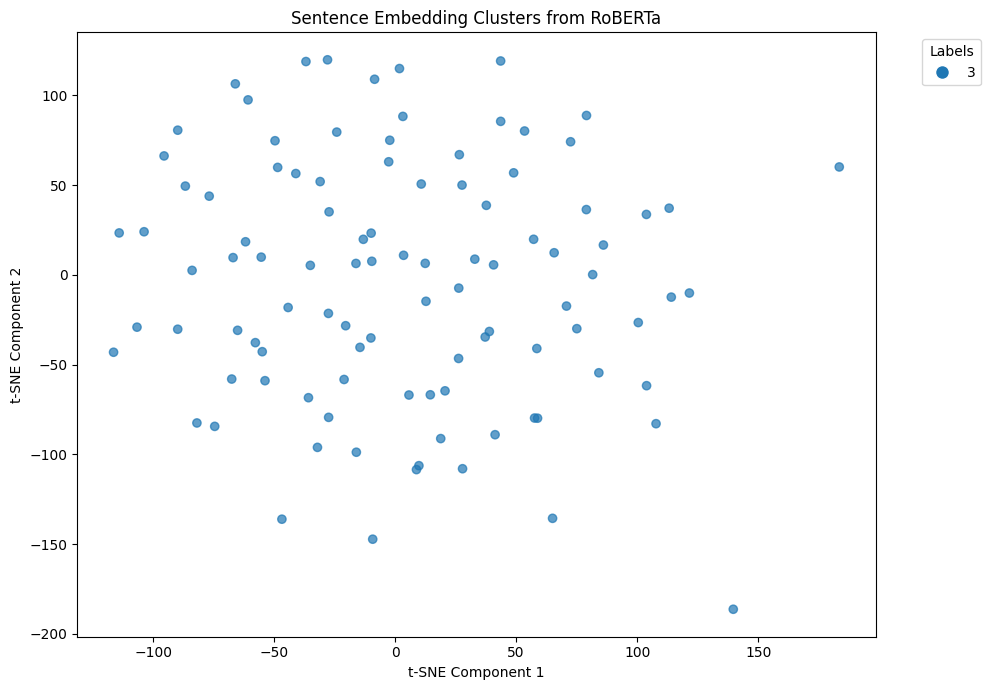

In [32]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assume `embeddings` shape is [num_samples, embedding_dim]
# And `df['labels']` contains the class labels

# 1. Reduce dimensionality using t-SNE
tsne = TSNE(n_components=3, random_state=42)
reduced = tsne.fit_transform(embeddings)

# 2. Encode labels to integers for coloring
labels = df['label'][:len(reduced)]
label_codes = labels.astype('category').cat.codes
unique_labels = labels.astype('category').cat.categories

# 3. Plot with proper coloring and legend
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=label_codes, cmap='tab10', alpha=0.7)

# 4. Create a custom legend
handles = []
for i, label in enumerate(unique_labels):
    handles.append(plt.Line2D([], [], marker='o', color='w', markerfacecolor=plt.cm.tab10(i/10), label=label, markersize=10))
plt.legend(handles=handles, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Sentence Embedding Clusters from RoBERTa")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.tight_layout()
plt.show()


# SHAP: To understand which tokens shape the model's decision, by identifying positive and negative contributors.

In [22]:
from transformers import pipeline
import shap

# 1. Create a pipeline with return_all_scores=True for SHAP compatibility
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

# 2. Wrap the pipeline with a SHAP explainer
explainer = shap.Explainer(pipe)

# 3. Get and truncate the input text
text = df['text'][0][:510]
# text="The government asked people to refrain from taking vaccines"

# Tokenize the input to ensure truncation matches model expectations
tokens = tokenizer.tokenize(text)

# Leave space for [CLS] and [SEP]
max_tokens = 510
truncated_tokens = tokens[:max_tokens]

# Convert back to a string
truncated_text = tokenizer.convert_tokens_to_string(truncated_tokens)

# 4. Explain the prediction on the sample
shap_values = explainer([truncated_text])

# 5. Plot SHAP values over tokens
shap.plots.text(shap_values[0])


Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/498 [00:00<?, ?it/s]

           ISON  -0.0112
                  0.0081
             AD   0.0033
              M  -0.0002


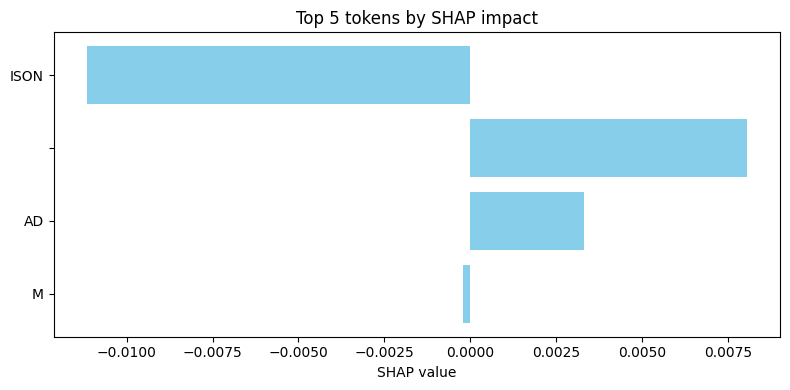

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Figure out which class we’re explaining
probs = pipe([truncated_text])[0]
pred_class = np.argmax([p["score"] for p in probs])

# 2) Get the SHAP Explanation for sample 0
expl0 = shap_values[0]    # <-- not shap_values[pred_class][0]

# 3) Extract tokens and the values for our predicted class
tokens = np.array(expl0.data)               # list of the T token strings
values = expl0.values[pred_class]           # shape (T,)

# 4) Sort by absolute impact and take the top 5
abs_vals   = np.abs(values)
top_idx    = np.argsort(-abs_vals)[:5]
top_tokens = tokens[top_idx]
top_vals   = values[top_idx]

# 5) (Optional) Print them
for tok, val in zip(top_tokens, top_vals):
    print(f"{tok:>15}  {val: .4f}")

# 6) Plot them
plt.figure(figsize=(8,4))
y_pos = np.arange(len(top_tokens))
plt.barh(y_pos, top_vals, align="center", color="skyblue")
plt.yticks(y_pos, top_tokens)
plt.gca().invert_yaxis()     # highest-impact on top
plt.xlabel("SHAP value")
plt.title("Top 5 tokens by SHAP impact")
plt.tight_layout()
plt.show()


In [24]:
!pip install bertopic umap-learn hdbscan

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

# 1. Compute document embeddings via your fine-tuned tokenizer+model
from transformers import AutoModel, AutoTokenizer
import torch

encoder = AutoModel.from_pretrained("roberta-base").to(device)
tok     = AutoTokenizer.from_pretrained("roberta-base")

def embed(texts):
    enc = tok(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad(): out = encoder(**enc)[0][:,0]   # [CLS] token
    return out.cpu().numpy()

docs      = df["cleaned_text"].tolist()
embeddings= embed(docs)

# 2. Fit BERTopic
topic_model = BERTopic(embedding_model=None,   # we pass our own
                       vectorizer_model=CountVectorizer(ngram_range=(1,2)),
                       umap_model=None,
                       hdbscan_model=None)
topics, probs = topic_model.fit_transform(docs, embeddings)

# 3. Inspect & visualize
print(topic_model.get_topic_info().head())
topic_model.visualize_topics()


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OutOfMemoryError: CUDA out of memory. Tried to allocate 13.08 GiB. GPU 0 has a total capacity of 14.74 GiB of which 12.38 GiB is free. Process 319075 has 2.35 GiB memory in use. Of the allocated memory 1.98 GiB is allocated by PyTorch, and 259.45 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [25]:
!pip install gensim pyLDAvis

import gensim, gensim.corpora as corpora
import pyLDAvis.gensim_models

# 1. Preprocess tokens
texts_tok = [doc.split() for doc in df["cleaned_text"]]
id2word   = corpora.Dictionary(texts_tok)
corpus    = [id2word.doc2bow(t) for t in texts_tok]

# 2. Train LDA
lda = gensim.models.LdaModel(corpus, num_topics=10, id2word=id2word, passes=10)

# 3. Visualize
vis = pyLDAvis.gensim_models.prepare(lda, corpus, id2word)
pyLDAvis.display(vis)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you ha

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

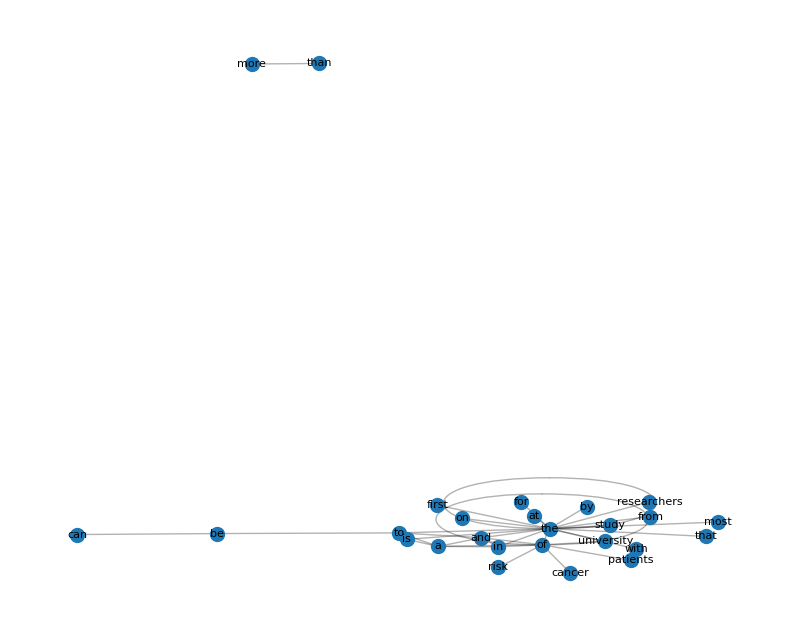

In [27]:
!pip install networkx matplotlib

import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

# Example: word co-occurrence in the first 100 docs
window = 5
pairs = []
for doc in df["cleaned_text"].iloc[:100]:
    words = doc.split()
    for i in range(len(words)-window+1):
        window_words = words[i:i+window]
        pairs += combinations(window_words, 2)

# Count top 50 co-occurrences
cnt = Counter(pairs)
top = cnt.most_common(50)

# Build and plot
G = nx.Graph()
for (w1,w2), freq in top:
    G.add_edge(w1, w2, weight=freq)

pos = nx.spring_layout(G, k=0.3)
plt.figure(figsize=(10,8))
nx.draw_networkx_nodes(G, pos, node_size=100)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.axis("off")
plt.show()


In [28]:
from sklearn.metrics.pairwise import cosine_similarity

# embeddings from before (docs × D)
sim = cosine_similarity(embeddings)
threshold = 0.7

G = nx.Graph()
n = len(docs)
for i in range(n):
    G.add_node(i, title=docs[i][:30]+"…")
    for j in range(i+1, n):
        if sim[i,j] > threshold:
            G.add_edge(i, j, weight=sim[i,j])

# visualize similarly, or export to Gephi via nx.write_gexf(G, "doc_graph.gexf")


IndexError: index 100 is out of bounds for axis 1 with size 100

ValueError: 'c' argument has 8927 elements, which is inconsistent with 'x' and 'y' with size 100.

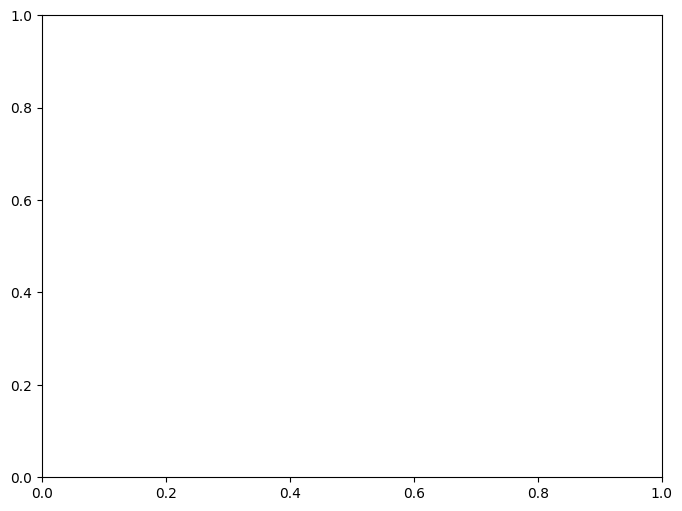

In [29]:
!pip install umap-learn

import umap
import matplotlib.pyplot as plt

# reduce to 2D
um = umap.UMAP(n_components=2)
proj = um.fit_transform(embeddings)

# color by label
labels = df["label"].values
plt.figure(figsize=(8,6))
scatter = plt.scatter(proj[:,0], proj[:,1], c=labels, cmap="tab10", s=5)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()


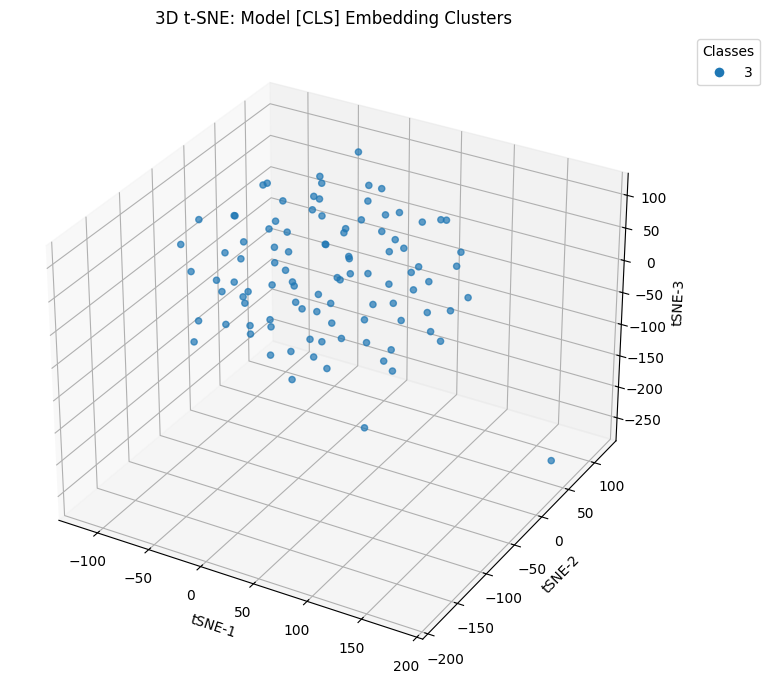

In [31]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

def get_cls_embeddings(texts, model, tokenizer, device):
    model.eval()
    embeddings = []
    # Determine the base transformer module dynamically
    base_transformer = getattr(model, model.base_model_prefix)
    for text in texts:
        inputs = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=512
        ).to(device)
        with torch.no_grad():
            # Call the base model directly to get hidden states
            outputs = base_transformer(**inputs)
        # last_hidden_state: (1, seq_len, hidden_dim)
        cls_emb = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(cls_emb.squeeze())
    return np.vstack(embeddings)

# Usage example (ensure model & tokenizer are loaded and on CPU/GPU as appropriate):
device = device  # reuse your device variable
sample_texts = df['cleaned_text'].iloc[:100].tolist()
embeddings = get_cls_embeddings(sample_texts, model, tokenizer, device)

# Run t-SNE in 3D
tsne = TSNE(n_components=3, random_state=42, perplexity=30)
reduced = tsne.fit_transform(embeddings)

# Prepare labels
labels = df['label'].iloc[:len(reduced)].astype('category')
label_codes = labels.cat.codes
unique_labels = labels.cat.categories

# Plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    reduced[:,0], reduced[:,1], reduced[:,2],
    c=label_codes, cmap='tab10', alpha=0.7
)
handles = [
    plt.Line2D([], [], marker='o', color='w',
               markerfacecolor=plt.cm.tab10(i/10), label=lbl, markersize=8)
    for i, lbl in enumerate(unique_labels)
]
ax.legend(handles=handles, title="Classes", loc='upper left', bbox_to_anchor=(1.05,1))
ax.set_title("3D t-SNE: Model [CLS] Embedding Clusters")
ax.set_xlabel("tSNE-1")
ax.set_ylabel("tSNE-2")
ax.set_zlabel("tSNE-3")
plt.tight_layout()
plt.show()


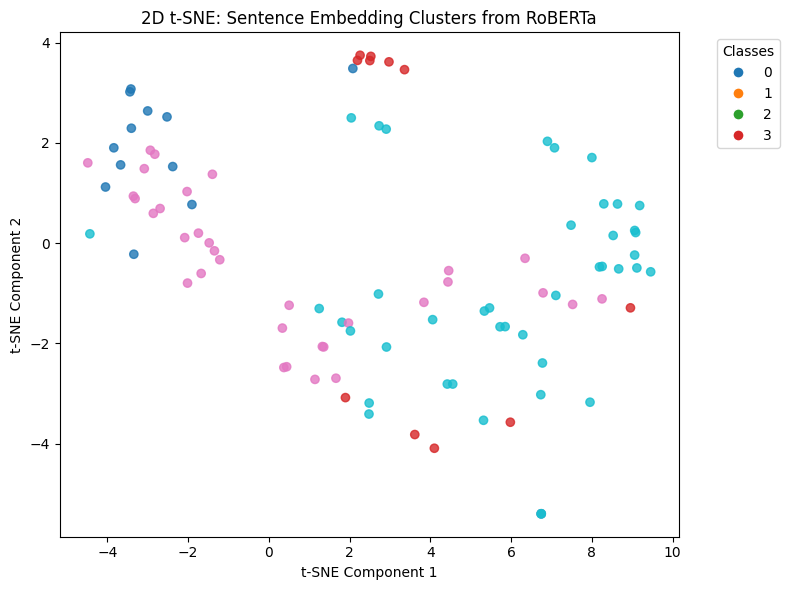

In [33]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# 1. Sample 100 examples *across* all classes
sample_df   = df.sample(n=100, random_state=42).reset_index(drop=True)
sample_texts= sample_df["cleaned_text"].tolist()

# 2. Compute CLS embeddings (CPU or GPU) – reuse your get_cls_embeddings
embeddings = get_cls_embeddings(sample_texts, model, tokenizer, device)

# 3. 2-D t-SNE
tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30)
reduced2 = tsne_2d.fit_transform(embeddings)

# 4. Prepare labels for coloring
labels        = sample_df["label"].astype("category")
label_codes   = labels.cat.codes
unique_labels = labels.cat.categories

# 5. Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    reduced2[:,0], reduced2[:,1],
    c=label_codes, cmap="tab10", alpha=0.8
)
# legend
handles = [
    plt.Line2D([],[], marker="o", color="w",
               markerfacecolor=plt.cm.tab10(i/10),
               label=lbl, markersize=8)
    for i,lbl in enumerate(unique_labels)
]
plt.legend(handles=handles, title="Classes", bbox_to_anchor=(1.05,1), loc="upper left")

plt.title("2D t-SNE: Sentence Embedding Clusters from RoBERTa")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.tight_layout()
plt.show()


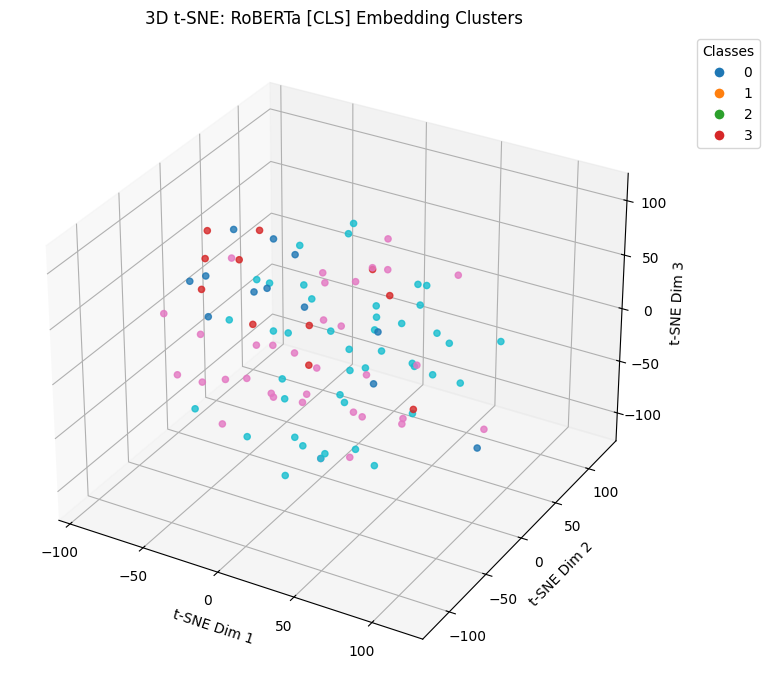

In [34]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import numpy as np

# 1. Re-use the same sample you drew above (or draw fresh):
sample_df    = df.sample(n=100, random_state=42).reset_index(drop=True)
sample_texts = sample_df["cleaned_text"].tolist()
embeddings   = get_cls_embeddings(sample_texts, model, tokenizer, device)

# 2. 3-component t-SNE
tsne_3d  = TSNE(n_components=3, random_state=42, perplexity=30)
reduced3 = tsne_3d.fit_transform(embeddings)

# 3. Labels
labels        = sample_df["label"].astype("category")
label_codes   = labels.cat.codes
unique_labels = labels.cat.categories

# 4. 3D plot
fig = plt.figure(figsize=(10,7))
ax  = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    reduced3[:,0], reduced3[:,1], reduced3[:,2],
    c=label_codes, cmap="tab10", alpha=0.8
)

# legend
handles = [
    plt.Line2D([],[], marker="o", color="w",
               markerfacecolor=plt.cm.tab10(i/10),
               label=lbl, markersize=8)
    for i,lbl in enumerate(unique_labels)
]
ax.legend(handles=handles, title="Classes", bbox_to_anchor=(1.05,1), loc="upper left")

# axes & title
ax.set_title("3D t-SNE: RoBERTa [CLS] Embedding Clusters")
ax.set_xlabel("t-SNE Dim 1")
ax.set_ylabel("t-SNE Dim 2")
ax.set_zlabel("t-SNE Dim 3")
plt.tight_layout()
plt.show()
